In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/mie1624/courseProject")  # change the current directory
os.getcwd()

'/content/drive/MyDrive/mie1624/courseProject'

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.utils import resample

%matplotlib inline

In [5]:
original    = pd.read_csv("clean_kaggle_data_2020.csv")
us_ca   = original.loc[(original["Q3"] == "Canada") | (original["Q3"] == "United States of America"), :]

#us_ca

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,206) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Cleaning

Drop the questions for non-professinal people.

In [6]:
mask        = us_ca.columns.str.contains("_B")
cleaned     = us_ca.loc[1:, ~mask].reset_index(drop=True) 

#cleaned.head() # for verification

Dropped the columns with less than 5000 valid data points.


In [7]:
threshold   = 10729 - 5000  # threshold to ensure the required number of data points 
mask        = ~cleaned.columns.str.contains("_") & (cleaned.isnull().sum(axis=0) >= threshold).values
cleaned     = cleaned.loc[:, ~mask]

#cleaned.head() # for verification

Drop the columns containing Other and None answers for multiple-nominal choice questions

In [8]:
maskOther   = cleaned.columns.str.contains("OTHER")
maskNone    = np.roll(maskOther, -1)
cleaned     = cleaned.loc[:, ~(maskOther|maskNone)]

#cleaned.loc[cleaned["Q24_Encoded"] == 1, "Q24_buckets"]#.head() # for verification

# 2. Salary distribution across job titles

In [9]:
jobTitles       = cleaned["Q5"].unique()
jobTitles       = np.delete(jobTitles, np.where(jobTitles == "Other"))
salaryBuckets   = sorted(cleaned["Q24_Encoded"].unique())

salaryFreq      = pd.DataFrame(index=jobTitles)
for salary in salaryBuckets:
    maskSalary          = cleaned["Q24_Encoded"] == salary
    salaryFreq[salary]  = cleaned.loc[maskSalary, "Q5"].value_counts().sort_index()#.to_numpy

salaryFreqRatio = salaryFreq.apply(lambda x: x / x.sum(), axis=1)

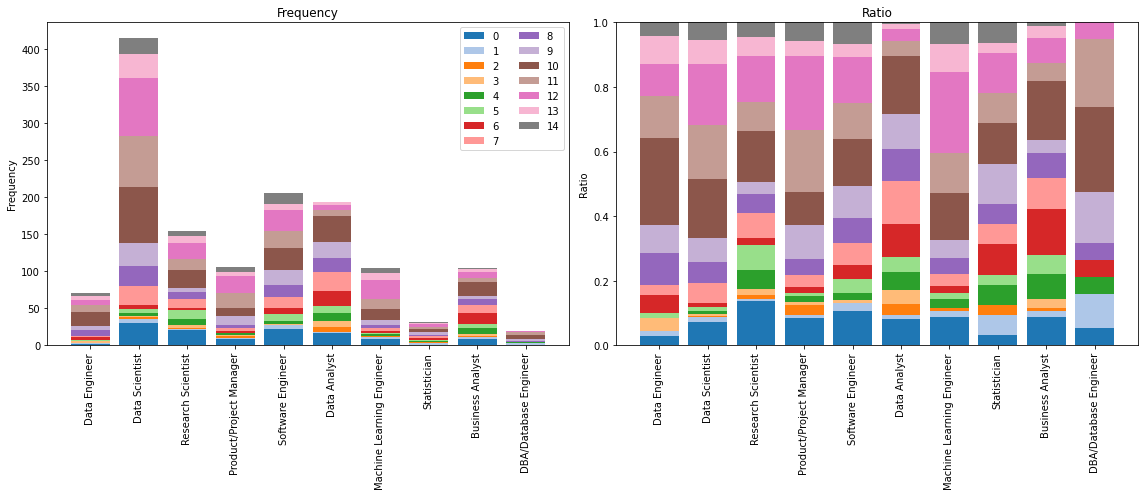

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7), tight_layout=True)
cmap = plt.get_cmap("tab20")

i   = 0 
for title, freq in salaryFreq.iteritems():
    stop    = salaryFreq.columns.get_loc(title)
    # plot the left figure
    ax[0].bar(jobTitles, freq, color=cmap(i), label=int(salaryBuckets[i]), bottom=salaryFreq.iloc[:, 0:stop].sum(axis=1))
    # plot the right figure
    ax[1].bar(jobTitles, salaryFreqRatio[i], color=cmap(i), bottom=salaryFreqRatio.iloc[:, 0:stop].sum(axis=1))
    # add 1 to the counter
    i  += 1

ax[0].set_title("Frequency")
ax[0].set_ylabel("Frequency")
ax[0].tick_params(axis="x", labelrotation= 90)
ax[0].legend(loc="upper right", ncol=2)
ax[1].set_title("Ratio")
ax[1].set_ylabel("Ratio")
ax[1].tick_params(axis="x", labelrotation= 90)

fig.savefig("salaryBarPlotParJobTitle.png")

# 3. Create heatmaps that describe the relation between job titles and other skill, experience, and so on

In [12]:
def createPivotTab(questions):
    df      = pd.DataFrame()#.atype("float32")
    answers = []
    for title in jobTitles:
        mask    = cleaned["Q5"] == title
        counts  = []
        for q in questions.columns:
            if len(answers) < len(questions.columns):
                answers.append(questions[q].value_counts().index[0])
            counts.append(cleaned.loc[mask, q].notna().sum())

        df[title] = counts

    df  = df.set_axis(answers, axis=0)

    return df

In [13]:
def normalizedHeatmap(df, ax=None):
    scaler  = MinMaxScaler()
    pivot   = createPivotTab(df)
    normalized  = pd.DataFrame(scaler.fit_transform(pivot), columns=pivot.columns, index=pivot.index)
    sns.heatmap(normalized, ax=ax#, square=True
                ).set(title="Normalized frequency par job title")

In [14]:
def drawHeatMaps(df):
    fig, axes   = plt.subplots(1, 2, tight_layout=True, sharey="row")

    pivot   = createPivotTab(df)
    sns.heatmap(pivot, ax=axes[0], square=True, cbar=False, annot=True, fmt="d").set(title="Frequency")
    normalizedHeatmap(df, axes[1])

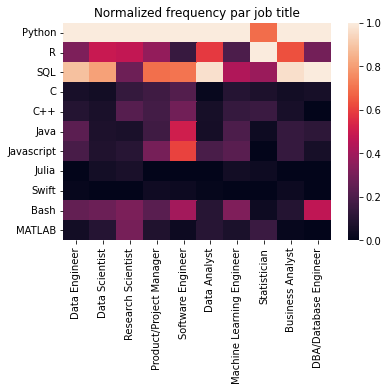

In [15]:
# Q7 What programming languages do you use on a regular basis? (Select all that apply)
normalizedHeatmap(cleaned.filter(like="Q7"))


fig.savefig("popularLang.png")

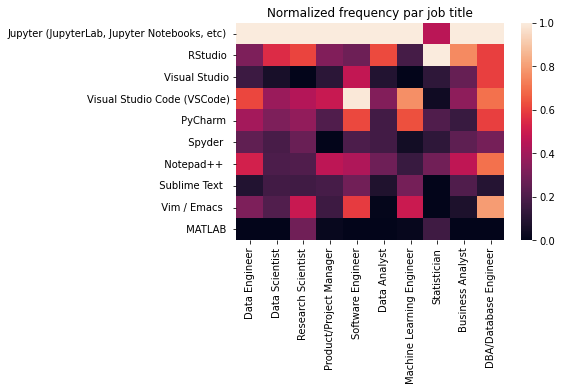

In [17]:
# Q9 Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply)
normalizedHeatmap(cleaned.filter(like="Q9")) 

fig.savefig("popularIDE.png")

In [ ]:
# Q10 Which of the following hosted notebook products do you use on a regular basis?  (Select all that apply) 
#normalizedHeatmap(cleaned.filter(like="Q10")) 

In [ ]:
# Q12 Which types of specialized hardware do you use on a regular basis?  (Select all that apply) 
#normalizedHeatmap(cleaned.filter(like="Q12"))

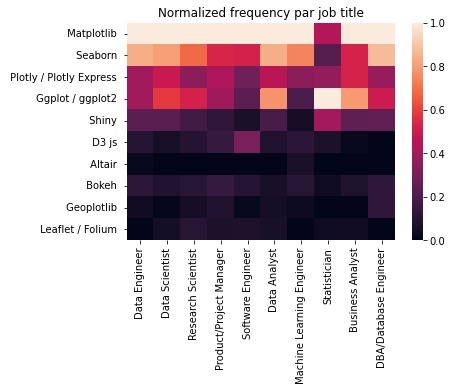

In [18]:
# Q14 What data visualization libraries or tools do you use on a regular basis?  (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q14")) 

fig.savefig("popularVisTool.png")

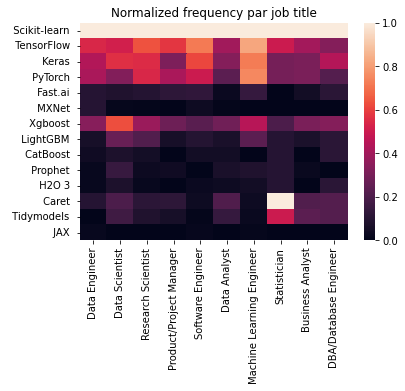

In [19]:
# Q16 Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q16"))

fig.savefig("popularMLFramework.png")

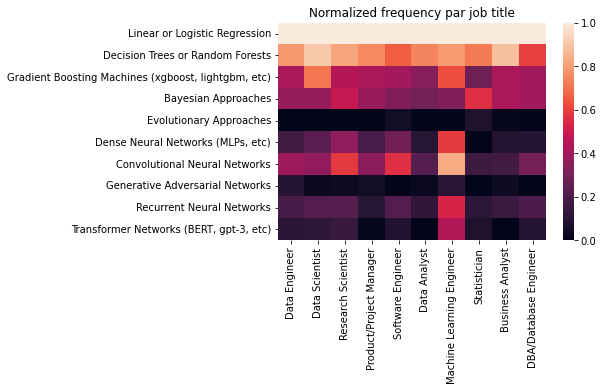

In [20]:
# Q17 Which of the following ML algorithms do you use on a regular basis? (Select all that apply): 
normalizedHeatmap(cleaned.filter(like="Q17")) 

fig.savefig("popularMLAlgo.png")

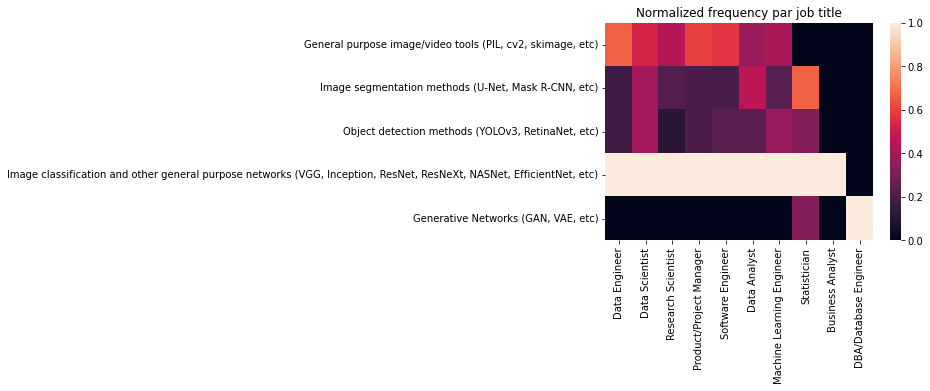

In [21]:
# Q18 Which categories of computer vision methods do you use on a regular basis?  (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q18")) 

fig.savefig("popularImgProc.png")

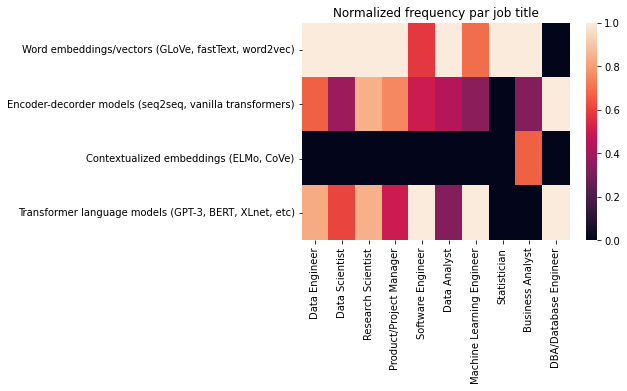

In [22]:
# Q19 Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply)
normalizedHeatmap(cleaned.filter(like="Q19")) 

fig.savefig("popularNLP.png")

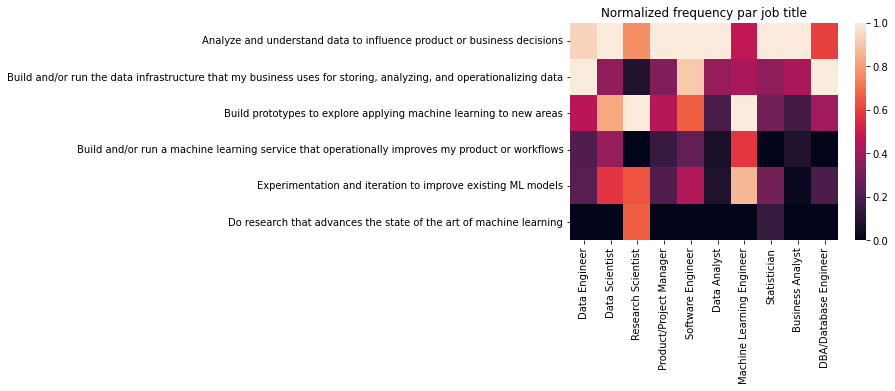

In [23]:
# Q23 Select any activities that make up an important part of your role at work: (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q23")) 

fig.savefig("roleAtWork.png")

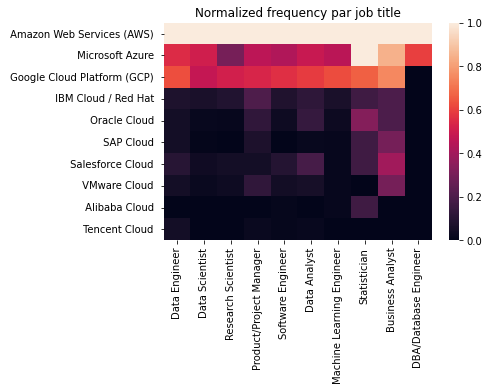

In [24]:
# Q26-A Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q26")) 

fig.savefig("popularCloudPlatform.png")

In [ ]:
# Q27-A Do you use any of the following cloud computing products on a regular basis? (Select all that apply)
#normalizedHeatmap(cleaned.filter(like="Q27")) 

In [ ]:
# Q28-A Do you use any of the following machine learning products on a regular basis? (Select all that apply)
#normalizedHeatmap(cleaned.filter(like="Q28")) 

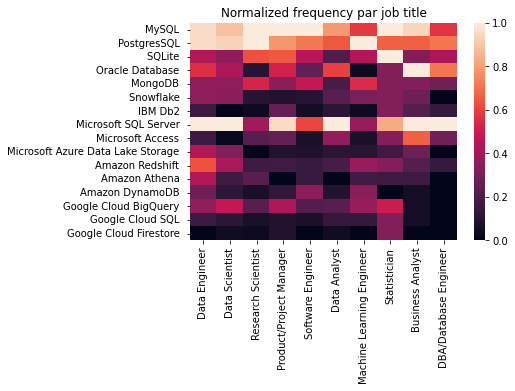

In [25]:
# Q29-A Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply)  
normalizedHeatmap(cleaned.filter(like="Q29")) 

fig.savefig("popularBigDataSvc.png")

In [26]:
# Q31-A Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) 
#normalizedHeatmap(cleaned.filter(like="Q31")) 

In [ ]:
# Q33-A Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) 
#normalizedHeatmap(cleaned.filter(like="Q33")) 

In [ ]:
# Q34-A Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis?  (Select all that apply)7 
#normalizedHeatmap(cleaned.filter(like="Q34")) 

In [27]:
# Q35-A Do you use any tools to help manage machine learning experiments? (Select all that apply) 
#normalizedHeatmap(cleaned.filter(like="Q35")) 

In [28]:
# Q36 Where do you publicly share or deploy your data analysis or machine learning applications? (Select all that apply) 
#normalizedHeatmap(cleaned.filter(like="Q36")) 

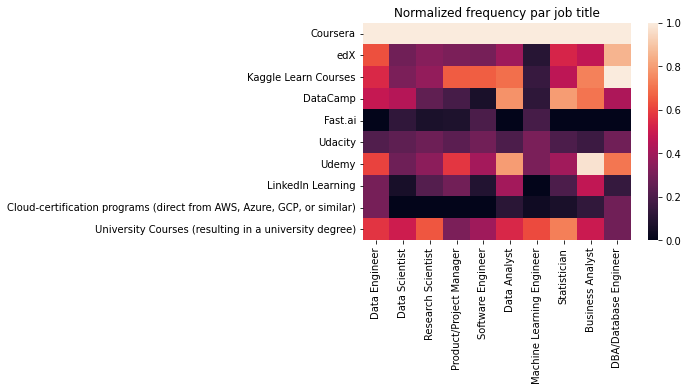

In [29]:
# Q37 On which platforms have you begun or completed data science courses? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q37")) 

# 3. Check correlation between the salary buckets and each multi-choice questions regarding skills, expertise, and so on.

In [37]:
multiNominalQs  = ["Q7", 
                   "Q9", "Q10", # <- about popular notebooks
#                   "Q12",   # <- useless since this quesion is about GPU/TPU
                   "Q14", 
                   "Q16", "Q17", "Q18", "Q19", 
                   "Q23", 
                   "Q26", 
#                   "Q27", "Q28",    # <- about cloud computing and ML products, respectively
                   "Q29", "Q31", 
#                   "Q33", "Q34",    # <- about AutoML tool
                   "Q35", "Q36"#, "Q37", "Q39"  # <- online learning service and favorite media about data science
                   ]

## Mann-Whitney's U test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


Ratio of answer choices that may explain significant differences in salary distributions through whether the choices were selected or not.


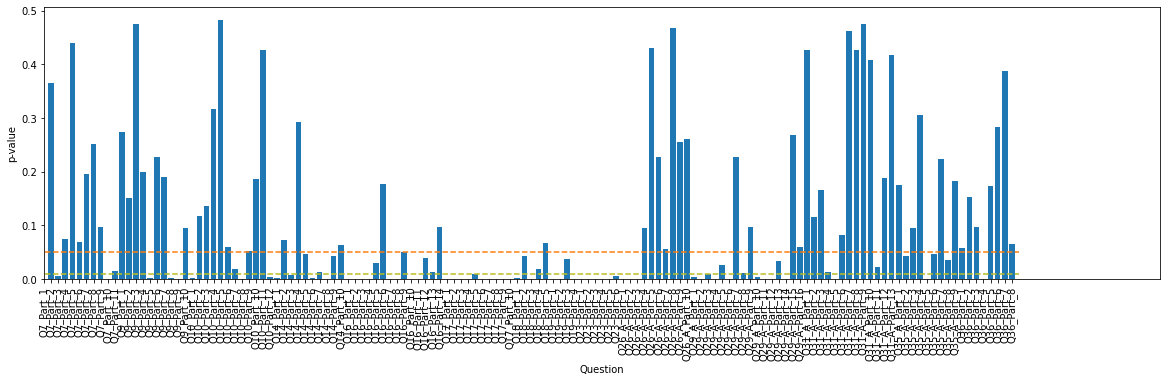

In [38]:
mwCols      = []
mwPVals     = []
mwPicked    = []
ratio       = pd.Series(index=multiNominalQs)

for q in multiNominalQs:
    count       = 0
    answerGroup = cleaned.filter(like=q)
    for col in answerGroup:
        mwCols.append(col)
        # mann-whitney U test
        rowMask     = cleaned[col].isna()
        negSamples  = cleaned.loc[rowMask, "Q24_Encoded"]
        posSamples  = cleaned.loc[~rowMask, "Q24_Encoded"]
        Z, p        = stats.mannwhitneyu(negSamples, posSamples)
        mwPVals.append(p)
        if p < 0.01:    # no processing: 237 -> <0.05: 182, <0.01: 367
            count  += 1

    ratio[q]    = count/len(answerGroup.columns)

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(mwCols, mwPVals)
ax.hlines([0.01, 0.05], -1, len(mwCols), colors=["tab:olive", "tab:orange"], linestyles="dashed")
ax.set_xlabel("Question")
ax.set_ylabel("p-value")
ax.set_xlim(0, 158)
ax.tick_params(axis='x', labelrotation=90)

print("Ratio of answer choices that may explain significant differences in salary distributions through whether the choices were selected or not.")
ratio.sort_values(ascending=False)
#mwPicked

fig.savefig("mwUTest.png")

In [39]:
def plotBootstrappedDist(question, description, figsize):
    rep = 200
    bs  = np.empty((2, rep))    # an array resampled data to be stored

    answerGroup = cleaned.filter(like=question)
    nRow        = (len(answerGroup.columns) + 1)//2
    nCol        = 2 if 1 < len(answerGroup.columns) else 1

    fig, axes   = plt.subplots(nRow, nCol, figsize=figsize, 
#                               tight_layout=True, 
                               sharey="row", sharex="col")

    fig.suptitle(description)
    for i in range(len(answerGroup.columns)):
        col = answerGroup.columns[i]
        maskSelect      = cleaned[col].notna()
        roxIdx, colIdx  = i//2, i%2
        for j in range(rep):
            negSalaries = cleaned.loc[~maskSelect, "Q24_Encoded"]
            posSalaries = cleaned.loc[maskSelect, "Q24_Encoded"]
            bs[0][j]    = np.median(resample(negSalaries, n_samples = len(negSalaries)))
            bs[1][j]    = np.median(resample(posSalaries, n_samples = len(posSalaries)))

        axes[roxIdx][colIdx].set_title("Answer choce %d" % (i + 1))
        axes[roxIdx][colIdx].hist([bs[0], bs[1]], bins=30, label=["not", "select"])
        axes[roxIdx][colIdx].set_xlim(0, 14)
        axes[roxIdx][colIdx].legend()

#    axes[roxIdx][colIdx].set_xlabel("Salary buckets")

In [ ]:
#plotBootstrappedDist("Q23", "Q23 Select any activities that make up an important part of your role at work", (12, 7))

In [32]:
def plotDistSelectOrNot(question, description, figsize):
    answerGroup = cleaned.filter(like=question)
    nRow        = (len(answerGroup.columns) + 1)//2
    nCol        = 2 if 1 < len(answerGroup.columns) else 1

    fig, axes   = plt.subplots(nRow, nCol, 
                               figsize=figsize, 
#                               tight_layout=True, 
                               sharey="row", sharex="col")

    fig.suptitle(question + ": " + description)
    for i in range(len(answerGroup.columns)):
        col = answerGroup.columns[i]
        maskSelect      = cleaned[col].notna()
        roxIdx, colIdx  = i//2, i%2

        axes[roxIdx][colIdx].set_title("Answer choce %d" % (i + 1))
        axes[roxIdx][colIdx].hist([cleaned.loc[~maskSelect, "Q24_Encoded"], cleaned.loc[maskSelect, "Q24_Encoded"]], 
                                  label=["not", "select"], 
                                  density=True, bins=15)
        axes[roxIdx][colIdx].legend()

    for i in range(nRow):
        axes[i][0].set_ylabel("Density")

    for i in range(nCol):
        axes[nRow - 1][i].set_xlabel("Salary buckets")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


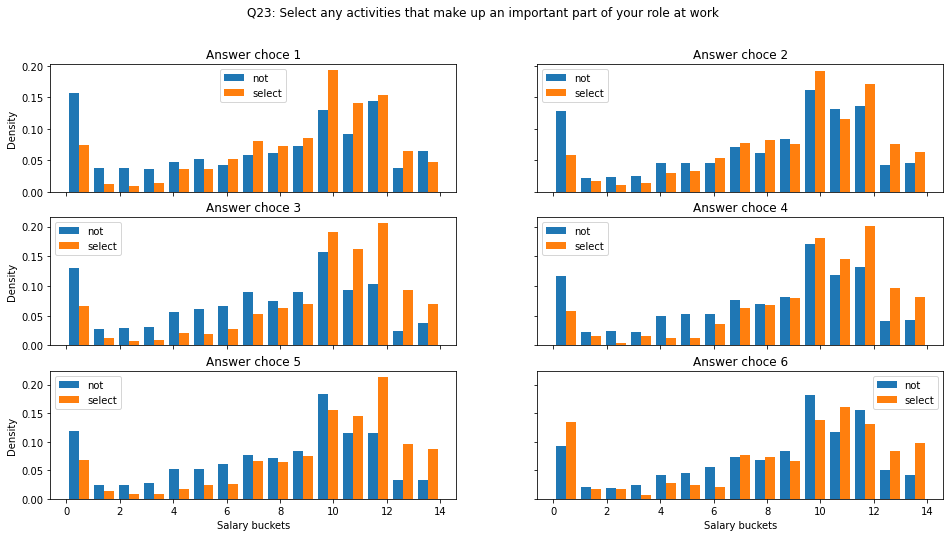

In [33]:
plotDistSelectOrNot("Q23", "Select any activities that make up an important part of your role at work", (16, 8))

fig.savefig("salaryDistQ23.png")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


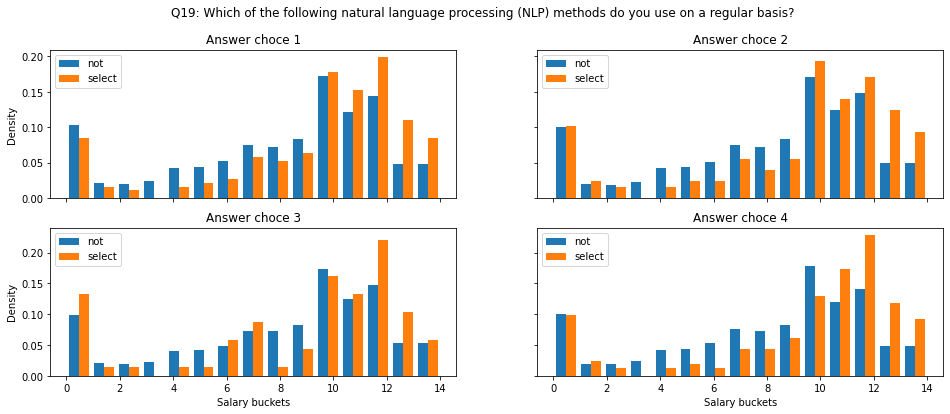

In [34]:
plotDistSelectOrNot("Q19", "Which of the following natural language processing (NLP) methods do you use on a regular basis?", (16, 6))

fig.savefig("salaryDistQ19.png")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


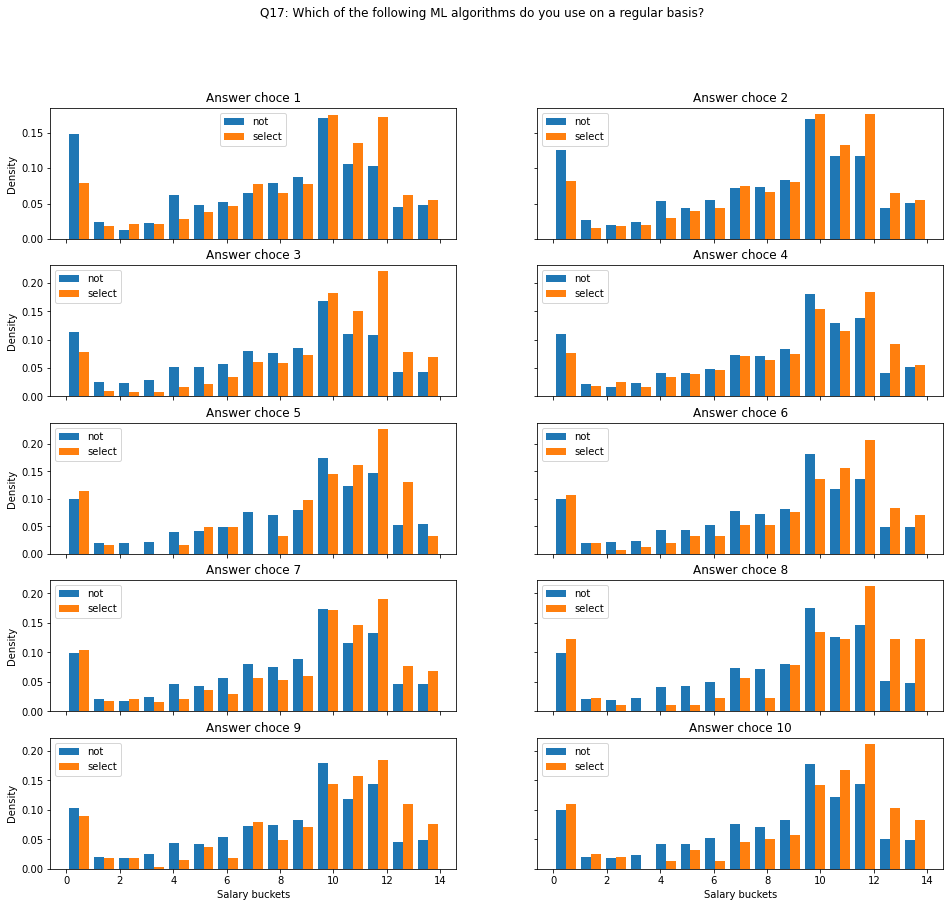

In [35]:
plotDistSelectOrNot("Q17", "Which of the following ML algorithms do you use on a regular basis?", (16, 14))

fig.savefig("salaryDistQ17.png")

## Point-biserial correlation

In [36]:
pbcorrCols      = []
pbcorrCoeffs    = []
pbcorrPVals     = []
pbcorrPicked    = []
for q in multiNominalQs:
    count   = 0
    for col in cleaned.filter(like=q):
        pbcorrCols.append(col)
        r, p        = stats.pointbiserialr(cleaned[col].notna(), cleaned["Q24_Encoded"])
        pbcorrCoeffs.append(r)
        pbcorrPVals.append(p)
        if p < 0.01:    # no processing: 237 -> r>0.2: 2, p<0.05: 177, p<0.01: 367
            pbcorrPicked.append(col)

fig, axes = plt.subplots(2, 1, 
                         figsize=(16, 10), tight_layout=True, 
                         sharex='col')

# upper graph
axes[0].bar(pbcorrCols, pbcorrCoeffs)
axes[0].hlines([0.2], -1, len(pbcorrCols), colors=["tab:orange"], linestyles="dashed")
axes[0].set_ylabel("Correlation coefficient")

# lower graph
axes[1].bar(pbcorrCols, pbcorrPVals)
axes[1].hlines([0.01, 0.05], -1, len(pbcorrCols), 
               colors=["tab:olive", "tab:orange"],  # olive and oragne dashed lines indicates α = 0.01 and 0.05, respectively 
               linestyles="dashed")
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_xlabel("Question")
axes[1].set_ylabel("p-value")

fig.savefig("pointBiserialCorr.png")
#pbcorrPicked

NameError: ignored